# Getting Started

In [1]:
# data analysis tools
import pandas as pd
import numpy as np
import simpy
import math
from scipy import stats

# graphic tools
from tqdm import tqdm
from pylab import plot, show, bar
import matplotlib.pyplot as plt
plt.style.use ("ggplot")

In [2]:
# 5% of predicted demand (according to our model) => taken from trial.xls
demand = [   142,   147,   153,   159,   165,   172,   178,   185,   192,   199,  
             207,   215,   223,   231,   239,   248,   257,   266,   276,   285,
             295,   306,   316,   327,   338,   349,   361,   373,   385,   397,
             409,   422,   435,   448,   462,   475,   489,   503,   516,   531,
             545,   559,   573,   588,   602,   616,   630,   645,   659,   673,
             686,   700,   713,   726,   739,   752,   764,   776,   787,   798,
             808,   818,   828,   837,   845,   852,   859,   866,   871,   876, 
             881,   884,   887,   889,   890,   891,   890,   889,   888,   885, 
             882,   878,   873,   868,   862,   856,   848,   840,   832,   823,
             813,   803,   793,   782,   771,   759,   747,   735,   722,   709, 
             696,   683,   669,   656,   642,   628,   614,   600,   586,   573, 
             559,   545,   531,   518,   504,   491,   478,   465,   452,   439,
             427,   414,   402,   390,   379,   367,   356,   345,   334,   324, 
             313,   303,   294,   284,   275,   266,   257,   248,   240,   232,
             224,   216,   209,   202,   195,   188,   181,   175,   169,   163   ]


""""""""" how we have loaded the demand from trial
file = pd.read_excel("trial.xls",sheet_name = "model_daily_demand")
demand = np.array(list(file["daily demand (patient)"]))
"""""""""

' how we have loaded the demand from trial\nfile = pd.read_excel("trial.xls",sheet_name = "model_daily_demand")\ndemand = np.array(list(file["daily demand (patient)"]))\n'

# Simulation Objects

In [3]:
class Patient (object):
    def __init__(self, env): 
        self.env = env
        
        self.arrival_time_queue1 = 0
        self.arrival_time_queue2 = 0
        # sampling the patient's patiences for each queue
        self.patience_automatic_machine = max (0, np.random.triangular (3/60, 4/60, 5/60))
        self.patience_medical_staff = max (0, np.random.triangular (15/60, 20/60, 45/60))
        
        if np.random.uniform (0, 1) > 0.55:   #  the cumulative distribution of coverage - from part A
            self.age = 1                      #  older than 65
        else:
            self.age = 0                      #  younger than 65

In [4]:
class Clinic (object):
    def __init__(self, env, automatic_machine, medical_staff):
        self.env = env
        self.automatic_machine = simpy.Resource (env, capacity = automatic_machine)     # a regular resource
        self.medical_staff = simpy.Resource (env, capacity = medical_staff)             # a regular resource

# Simulation Events

In [5]:
def patient_arrivals (env, clinic):
    global simulation_total_patients
    
    while env.now < clinic_open_hours:    # keep the clinic open for arrivals until the simulation time ends (12 hpurs)
        yield env.timeout (np.random.exponential (clinic_open_hours/demand[day]))  # pausing the system for the patient's arrival
        new_patient = Patient (env)                                                # creating new patient
        simulation_total_patients+= 1                                              # updating number of patients arrived today
        env.process (queue1 (env, clinic, new_patient))                   # enter the queue for getting a note from the machine

In [6]:
def queue1 (env, clinic, patient):        # The queue for the automatic machine    
    global simulation_wait_time_queue1
    global simulation_service_time_queue1
    global simulation_abandoning_patients_over_65_queue1
    global simulation_abandoning_patients_under_65_queue1
    
    patient.arrival_time_queue1 = env.now                                # check in entrance time for queue 1
    
    with clinic.automatic_machine.request() as my_turn:                  # request to use automatic machines resource
        result = yield my_turn | env.timeout (patient.patience_automatic_machine) 
        
        # result => leave: the turn ended because the patient has left the clinic (the customer has no patience)
        if my_turn not in result:                                      
            wait_time = patient.patience_automatic_machine              
            simulation_wait_time_queue1.append (wait_time)                   # documenting wait time
            
            # updating the number of abandoning patients, by age
            if patient.age == 1: 
                simulation_abandoning_patients_over_65_queue1+= 1
            else:
                simulation_abandoning_patients_under_65_queue1+= 1

        # result => service: the turn ended because the patient's turn has come
        if my_turn in result:
            wait_time = env.now - patient.arrival_time_queue1           
            simulation_wait_time_queue1.append (wait_time)                  # documenting wait time
            
            # calculating the operation time of the patient, by age
            if patient.age == 1:
                service_time = max (0, np.random.normal (30/3600, 8/3600))  # time for people older 65 years old
            else:  
                service_time = max (0, np.random.normal (20/3600, 5/3600))  # time for people younger 65 years old
            
            yield env.timeout (service_time)                                # pausing the system for the operation time
            simulation_service_time_queue1.append (service_time)            # documenting service time
            env.process (queue2 (env, clinic, patient))                 # enter the queue for getting a vaccination from a nurse

In [7]:
def queue2 (env ,clinic, patient):        # The queue for the medical staff
    global simulation_wait_time_queue2
    global simulation_service_time_queue2
    global simulation_abandoning_patients_over_65_queue2
    global simulation_abandoning_patients_under_65_queue2
    global simulation_vaccinated_patients

    patient.arrival_time_queue2 = env.now                              # check in entrance time for queue 2
        
    with clinic.medical_staff.request() as my_turn:                    # request to use medical_staff resource
        result = yield my_turn | env.timeout (patient.patience_medical_staff)  
        
        # result => leave: the turn ended because the patient has left the clinic (the customer has no patience)
        if my_turn not in result:
            wait_time = patient.patience_medical_staff                 
            simulation_wait_time_queue2.append (wait_time)                 # documenting wait time
            
            # updating the number of abandoning patients, by age
            if patient.age == 1:
                simulation_abandoning_patients_over_65_queue2+= 1
            
            else:
                simulation_abandoning_patients_under_65_queue2+= 1

        # result => service: the turn ended because the patient's turn has come
        if my_turn in result:
            wait_time = env.now - patient.arrival_time_queue2
            simulation_wait_time_queue2.append (wait_time)                # documenting wait time
            
            # calculating the operation time of the patient
            walk_time = np.random.uniform (20/3600, 60/3600)
            vaccination_time = np.random.uniform (2/60, 3/60)
            call_next_patient_time = 10/3600
            service_time = vaccination_time + call_next_patient_time
            
            yield env.timeout (walk_time + service_time)                 # pausing the system for the operation time
            simulation_service_time_queue2.append (service_time)         # documenting service time
            simulation_vaccinated_patients+= 1                           # updating the number of vaccinated patients

# Simulation Parameters

In [8]:
clinic_open_hours = 12
machine_maintance_hour = 20
nurse_salary_hour = 55
revenue_vaccination = 60
cost_vaccination = 40
cost_abandoners_over_65 = 10000
cost_abandoners_under_65 = 5000
num_of_machines = 2
num_of_nurses = 5

# Step 1.1: Finding Initial Values

In [9]:
N0 = 5
alpha = 0.05
epsilon= 0.1
random_seed = 42
np.random.seed (random_seed)
t = stats.t.ppf (1 - alpha/2, N0 - 1)
z = stats.norm.ppf (1 - alpha/2)

# data from every season simulation (5 arrays of 150 days)
profit = np.zeros (shape = (N0, 150))

wait_time = np.zeros (shape = (N0, 150))
wait_time_queue1 = np.zeros (shape = (N0, 150))
wait_time_queue2 = np.zeros (shape = (N0, 150))

efficiency_machine = np.zeros (shape = (N0, 150))
efficiency_medical_staff = np.zeros (shape = (N0, 150))

abandoning_patients_over_65 = np.zeros (shape = (N0, 150))
abandoning_patients_under_65 = np.zeros (shape = (N0, 150))
abandoning_patients = np.zeros (shape = (N0, 150))

vaccinated_patients = np.zeros (shape = (N0, 150))
total_patients = np.zeros (shape = (N0, 150))

for season in tqdm (range (N0)):
    for day in range (150): #each iteration represents a day in season
        # data from every-day simulation (reset each day)
        simulation_wait_time_queue1 = []
        simulation_wait_time_queue2 = []

        simulation_service_time_queue1 = []
        simulation_service_time_queue2 = []

        simulation_abandoning_patients_over_65_queue1 = 0
        simulation_abandoning_patients_over_65_queue2 = 0
        
        simulation_abandoning_patients_under_65_queue1 = 0
        simulation_abandoning_patients_under_65_queue2 = 0
        
        simulation_total_patients = 0
        simulation_vaccinated_patients = 0
            
        env = simpy.Environment ()
        clinic = Clinic (env, 2, 5)
        
        # Start process and run
        env.process (patient_arrivals (env, clinic))
        env.run ()
        clinic_actual_hours = env.now
        
        # Calculate parameters for each day of the season:
        abandoning_patients_over_65[season][day]  = simulation_abandoning_patients_over_65_queue1 + \
                                                    simulation_abandoning_patients_over_65_queue2
            
        abandoning_patients_under_65[season][day] = simulation_abandoning_patients_under_65_queue1 + \
                                                    simulation_abandoning_patients_under_65_queue2
        
        abandoning_patients[season][day] = abandoning_patients_over_65[season][day] + \
                                           abandoning_patients_under_65[season][day]
        
        wait_time_queue1[season][day] = sum (simulation_wait_time_queue1)/simulation_total_patients
        
        wait_time_queue2[season][day] = sum (simulation_wait_time_queue2)/(simulation_total_patients - \
                                                                           simulation_abandoning_patients_over_65_queue1 - \
                                                                           simulation_abandoning_patients_under_65_queue1)
        
        wait_time[season][day] = wait_time_queue1[season][day] + wait_time_queue2[season][day]
        
        efficiency_machine[season][day] = sum (simulation_service_time_queue1)/(clinic_actual_hours*num_of_machines)
        efficiency_medical_staff[season][day] = sum (simulation_service_time_queue2)/(clinic_actual_hours*num_of_nurses)
        
        vaccinated_patients[season][day] = simulation_vaccinated_patients
        total_patients[season][day] = simulation_total_patients
        
        profit[season][day] = revenue_vaccination * simulation_vaccinated_patients - \
                              clinic_actual_hours * nurse_salary_hour * num_of_nurses - \
                              clinic_actual_hours * efficiency_machine[season][day] * machine_maintance_hour - \
                              cost_vaccination * simulation_total_patients - \
                              cost_abandoners_over_65 * abandoning_patients_over_65[season][day] - \
                              cost_abandoners_under_65 * abandoning_patients_under_65[season][day]

100%|██████████| 5/5 [01:10<00:00, 14.08s/it]


In [10]:
# calculating all averages between days, in each season => array of 150 averages
avg_wait_time = np.average (wait_time, axis = 0)
avg_wait_time_queue1 = np.average (wait_time_queue1, axis = 0)
avg_wait_time_queue2 = np.average (wait_time_queue2, axis = 0)
avg_abandoning_patients = np.average (abandoning_patients, axis = 0)
avg_efficiency_machine = np.average (efficiency_machine, axis = 0)
avg_efficiency_medical_staff = np.average (efficiency_medical_staff, axis = 0)

# calculating sum of profit every season => array of 5 seasonal profits
sum_profit = np.sum(profit, axis = 1)

In [11]:
# calculating all standard deviations between days, in each season => array of 150 std
std_of_wait_time = np.std (wait_time, axis = 0)
std_of_wait_time_queue1 = np.std (wait_time_queue1, axis = 0)
std_of_wait_time_queue2 = np.std (wait_time_queue2, axis = 0)
std_of_abandoning_patients = np.std (abandoning_patients, axis = 0)
std_of_efficiency_machine = np.std (efficiency_machine, axis = 0)
std_of_efficiency_medical_staff = np.std (efficiency_medical_staff, axis = 0)

# calculating the standard deviation for season profit => 1 std
std_of_profit = np.std (sum_profit)

In [12]:
# calculating all scalar average values, due to the arrays
A_wait_time = np.mean (avg_wait_time) 
A_wait_time_queue1 = np.mean (avg_wait_time_queue1)
A_wait_time_queue2 = np.mean (avg_wait_time_queue2)
A_abandoning_patients = np.mean (avg_abandoning_patients)
A_efficiency_machine = np.mean (avg_efficiency_machine)
A_efficiency_medical_staff = np.mean (avg_efficiency_medical_staff)
A_profit = np.mean (sum_profit)
A_profit_min = A_profit - (t * std_of_profit)/math.sqrt(N0)
A_profit_max = A_profit + (t * std_of_profit)/math.sqrt(N0)

print ("--------- Daily Averages ---------")
print ("Wait Time (for patient):", A_wait_time * 3600, "seconds")
print ("Wait Time (for patient) for Automatic Machine:", A_wait_time_queue1 * 3600, "seconds")
print ("Wait Time (for patient) for Nurse:", A_wait_time_queue2 * 3600, "seconds")
print ("Number of Abandoning Patients:", A_abandoning_patients, "patients")
print ("Efficiency for Automatic Machine:", A_efficiency_machine * 100, "%")
print ("Efficiency for Nurse:", A_efficiency_medical_staff * 100, "%")

print ("\n--------- Annual Averages ---------")
print ("Profit:", A_profit, "NIS")
print ("Confidence Interval for Profit:", [A_profit_min, A_profit_max])

--------- Daily Averages ---------
Wait Time (for patient): 18.2007396002 seconds
Wait Time (for patient) for Automatic Machine: 0.43980654557 seconds
Wait Time (for patient) for Nurse: 17.7609330546 seconds
Number of Abandoning Patients: 0.0 patients
Efficiency for Automatic Machine: 14.302571612 %
Efficiency for Nurse: 37.3634879691 %

--------- Annual Averages ---------
Profit: 1061808.83227 NIS
Confidence Interval for Profit: [1060440.4449866777, 1063177.2195609189]


# Step 1.2: Calculating Number Of Iterations

In [13]:
def Calculate_N_t (A_index, std_max, N):
    h = epsilon * A_index
    if h == 0:
        h = 1
        h0 = 0
    h0 = (t * std_max)/math.sqrt(N)
    N_max = N*(h0/h)**2
    return math.ceil (N_max)

In [14]:
def Calculate_N_z (A_index, std_max, p, N):
    h = epsilon * A_index
    if h == 0:
        h = 1
        h0 = 0
    h0 = z * math.sqrt(p*(1-p)/N)
    N_max = N*(h0/h)**2
    return math.ceil (N_max)

In [15]:
# finding the maximal standard deviation, which defines the maximal number of iterations needed
max_std_wait_time = max (std_of_wait_time)
max_std_wait_time_queue1 = max (std_of_wait_time_queue1)
max_std_wait_time_queue2 = max (std_of_wait_time_queue2)
max_std_abandoning_patients = max (std_of_abandoning_patients)
max_std_efficiency_machine = max (std_of_efficiency_machine)
max_std_efficiency_medical_staff = max (std_of_efficiency_medical_staff)
max_std_profit = std_of_profit

# using the functions above in order to calculate number of iterations for each index
N_wait_time = Calculate_N_t (A_wait_time, max_std_wait_time, 150)
N_wait_time_queue1 = Calculate_N_t (A_wait_time_queue1 , max_std_wait_time_queue1, 150)
N_wait_time_queue2 = Calculate_N_t (A_wait_time_queue2 , max_std_wait_time_queue2, 150)
N_abandoning_patients = Calculate_N_t (A_abandoning_patients, max_std_abandoning_patients, 150)
N_efficiency_machine = Calculate_N_z (A_efficiency_machine, max_std_efficiency_machine, A_efficiency_machine, 150)
N_efficiency_medical_staff = Calculate_N_z (A_efficiency_medical_staff, max_std_efficiency_medical_staff, A_efficiency_machine, 150)
N_profit = Calculate_N_t (A_profit, max_std_profit, 5)

print ("--------- Number of Iterations for Daily Averages ---------")
print ("Wait Time (for patient):", N_wait_time)
print ("Wait Time (for patient) for Automatic Machine:", N_wait_time_queue1)
print ("Wait Time (for patient) for Nurse:", N_wait_time_queue2)
print ("Abandoning Patients:", N_abandoning_patients)
print ("Efficiency for Automatic Machine:", N_efficiency_machine)
print ("Efficiency for Nurse:", N_efficiency_medical_staff)

print ("\n--------- Number of Iterations for Annual Averages ---------")
print ("Profit:", N_profit)

# choosing the index which demands the maximal iterations
N_max = max (N_wait_time, N_wait_time_queue1, N_wait_time_queue2, N_abandoning_patients,
             N_efficiency_machine, N_efficiency_medical_staff, N_profit)

print ("\n--------- Maximal Number of Iterations ---------")
print ("N =", N_max)

print ("\n--------- Final Conclusion ---------")
print ("Due to run-time constraints, we'll go through", max (N_profit, 20), "iterations.")

--------- Number of Iterations for Daily Averages ---------
Wait Time (for patient): 4042
Wait Time (for patient) for Automatic Machine: 464
Wait Time (for patient) for Nurse: 4183
Abandoning Patients: 0
Efficiency for Automatic Machine: 2302
Efficiency for Nurse: 338

--------- Number of Iterations for Annual Averages ---------
Profit: 1

--------- Maximal Number of Iterations ---------
N = 4183

--------- Final Conclusion ---------
Due to run-time constraints, we'll go through 20 iterations.


# Step 2.1: Running Simulation (Current State)

In [16]:
N = 20
alpha = 0.05
epsilon= 0.1
random_seed = 42
np.random.seed (random_seed)
t = stats.t.ppf (1 - alpha/2, N - 1)
z = stats.norm.ppf (1 - alpha/2)

# data from every season simulation (5 arrays of 150 days)
profit = np.zeros (shape = (N, 150))

wait_time = np.zeros (shape = (N, 150))
wait_time_queue1 = np.zeros (shape = (N, 150))
wait_time_queue2 = np.zeros (shape = (N, 150))

efficiency_machine = np.zeros (shape = (N, 150))
efficiency_medical_staff = np.zeros (shape = (N, 150))

abandoning_patients_over_65 = np.zeros (shape = (N, 150))
abandoning_patients_under_65 = np.zeros (shape = (N, 150))
abandoning_patients = np.zeros (shape = (N, 150))

vaccinated_patients = np.zeros (shape = (N, 150))
total_patients = np.zeros (shape = (N, 150))

for season in tqdm (range (N)):
    for day in range (150):
        # data from every-day simulation (reset each day)
        simulation_wait_time_queue1 = []
        simulation_wait_time_queue2 = []

        simulation_service_time_queue1 = []
        simulation_service_time_queue2 = []

        simulation_abandoning_patients_over_65_queue1 = 0
        simulation_abandoning_patients_over_65_queue2 = 0
        
        simulation_abandoning_patients_under_65_queue1 = 0
        simulation_abandoning_patients_under_65_queue2 = 0
        
        simulation_total_patients = 0
        simulation_vaccinated_patients = 0
        
        env = simpy.Environment ()
        clinic = Clinic (env, 2, 5)
        
        # Start process and run
        env.process (patient_arrivals (env, clinic))
        env.run ()
        clinic_actual_hours = env.now
        
        # Calculate parameters for each day of the season:
        abandoning_patients_over_65[season][day]  = simulation_abandoning_patients_over_65_queue1 + \
                                                    simulation_abandoning_patients_over_65_queue2
            
        abandoning_patients_under_65[season][day] = simulation_abandoning_patients_under_65_queue1 + \
                                                    simulation_abandoning_patients_under_65_queue2
        
        abandoning_patients[season][day] = abandoning_patients_over_65[season][day] + \
                                           abandoning_patients_under_65[season][day]
        
        wait_time_queue1[season][day] = sum (simulation_wait_time_queue1)/simulation_total_patients
        
        wait_time_queue2[season][day] = sum (simulation_wait_time_queue2)/(simulation_total_patients - \
                                                                           simulation_abandoning_patients_over_65_queue1 - \
                                                                           simulation_abandoning_patients_under_65_queue1)
        
        wait_time[season][day] = wait_time_queue1[season][day] + wait_time_queue2[season][day]
        
        efficiency_machine[season][day] = sum (simulation_service_time_queue1)/(clinic_actual_hours*num_of_machines)
        efficiency_medical_staff[season][day] = sum (simulation_service_time_queue2)/(clinic_actual_hours*num_of_nurses)
        
        vaccinated_patients[season][day] = simulation_vaccinated_patients
        total_patients[season][day] = simulation_total_patients
        
        profit[season][day] = revenue_vaccination * simulation_vaccinated_patients - \
                              clinic_actual_hours * nurse_salary_hour * num_of_nurses - \
                              clinic_actual_hours * efficiency_machine[season][day] * machine_maintance_hour - \
                              cost_vaccination * simulation_total_patients - \
                              cost_abandoners_over_65 * abandoning_patients_over_65[season][day] - \
                              cost_abandoners_under_65 * abandoning_patients_under_65[season][day]

100%|██████████| 20/20 [04:31<00:00, 13.55s/it]


# Step 2.2: Averages And Graphs (Current State)

In [17]:
# calculating all averages between days, in each season => array of 150 averages
avg_wait_time = np.average (wait_time, axis = 0)
avg_wait_time_queue1 = np.average (wait_time_queue1, axis = 0)
avg_wait_time_queue2 = np.average (wait_time_queue2, axis = 0)
avg_abandoning_patients = np.average (abandoning_patients, axis = 0)
avg_efficiency_machine = np.average (efficiency_machine, axis = 0)
avg_efficiency_medical_staff = np.average (efficiency_medical_staff, axis = 0)

# calculating sum of profit every season => array of 5 seasonal profits + standard deviation for C.I.
sum_profit = np.sum (profit, axis = 1)
std_of_profit = np.std (sum_profit)

In [18]:
# calculating all scalar average values, due to the arrays
A_wait_time = np.mean (avg_wait_time) 
A_wait_time_queue1 = np.mean (avg_wait_time_queue1)
A_wait_time_queue2 = np.mean (avg_wait_time_queue2)
A_abandoning_patients = np.mean (avg_abandoning_patients)
A_efficiency_machine = np.mean (avg_efficiency_machine)
A_efficiency_medical_staff = np.mean (avg_efficiency_medical_staff)
A_profit = np.mean (sum_profit)
A_profit_min = A_profit - (t * std_of_profit)/math.sqrt(N)
A_profit_max = A_profit + (t * std_of_profit)/math.sqrt(N)

print ("--------- Daily Averages ---------")
print ("Wait Time (for patient):", A_wait_time * 3600, "seconds")
print ("Wait Time (for patient) for Automatic Machine:", A_wait_time_queue1 * 3600, "seconds")
print ("Wait Time (for patient) for Nurse:", A_wait_time_queue2 * 3600, "seconds")
print ("Number of Abandoning Patients:", A_abandoning_patients, "patients")
print ("Efficiency for Automatic Machine:", A_efficiency_machine * 100, "%")
print ("Efficiency for Nurse:", A_efficiency_medical_staff * 100, "%")

print ("\n--------- Annual Averages ---------")
print ("Profit:", A_profit, "NIS")
print ("Confidence Interval for Profit:", [A_profit_min, A_profit_max])

--------- Daily Averages ---------
Wait Time (for patient): 17.8556741803 seconds
Wait Time (for patient) for Automatic Machine: 0.437332875545 seconds
Wait Time (for patient) for Nurse: 17.4183413048 seconds
Number of Abandoning Patients: 0.0 patients
Efficiency for Automatic Machine: 14.2955643867 %
Efficiency for Nurse: 37.3496938147 %

--------- Annual Averages ---------
Profit: 1061358.04736 NIS
Confidence Interval for Profit: [1059767.5234044343, 1062948.5713231354]


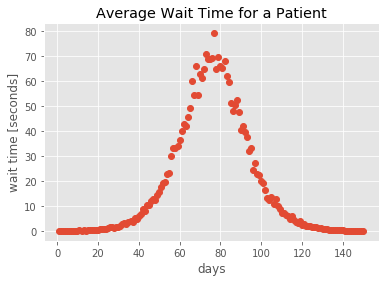

In [19]:
# create data of the simulation results 
Tx = np.linspace (1, 150, 150)
tx = avg_wait_time * 3600

# create graph representing the daily results
plt.plot (Tx, tx, 'o')
plt.title ("Average Wait Time for a Patient")
plt.xlabel ("days")
plt.ylabel ("wait time [seconds]")
plt.show ()

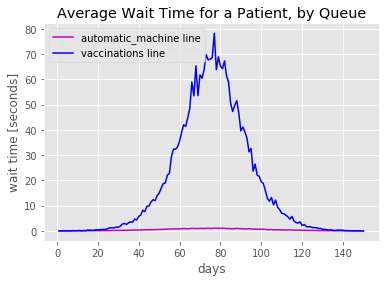

In [20]:
# create data of the simulation results 
Tx = np.linspace (1, 150, 150)
x1 = avg_wait_time_queue1 * 3600
x2 = avg_wait_time_queue2 * 3600

# create graph representing the daily results
plt.plot (Tx, x1, 'm', Tx, x2, 'b')
plt.title ("Average Wait Time for a Patient, by Queue")
plt.xlabel ("days")
plt.ylabel ("wait time [seconds]")
plt.legend (('automatic_machine line', 'vaccinations line'))
plt.show ()

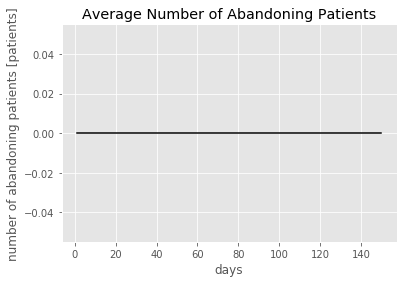

In [21]:
# create data of the simulation results 
Tx = np.linspace (1, 150, 150)
tx = avg_abandoning_patients

# create graph representing the daily results
plt.plot (Tx, tx, 'k')
plt.title ("Average Number of Abandoning Patients")
plt.xlabel ("days")
plt.ylabel ("number of abandoning patients [patients]")
plt.show ()

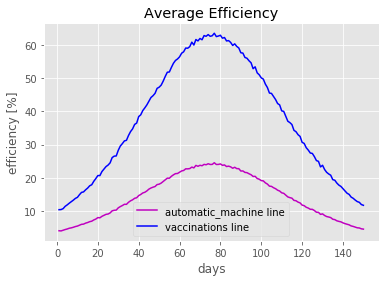

In [22]:
# create data of the simulation results 
Tx = np.linspace (1, 150, 150)
x1 = (avg_efficiency_machine) * 100
x2 = (avg_efficiency_medical_staff) * 100

# create graph representing the daily results
plt.plot (Tx, x1, 'm',Tx, x2, 'b')
plt.title ("Average Efficiency")
plt.xlabel ("days")
plt.ylabel ("efficiency [%]")
plt.legend (('automatic_machine line', 'vaccinations line'))
plt.show ()

# Step 3.1: Running Simulation (New State)

In [23]:
N = 20
alpha = 0.05
epsilon= 0.1
t = stats.t.ppf (1 - alpha/2, N - 1)
z = stats.norm.ppf (1 - alpha/2)

random_seed = 42
np.random.seed (random_seed)

# data from every season simulation (5 arrays of 150 days)
alternative_profit = np.zeros (shape = (N, 150))

wait_time = np.zeros (shape = (N, 150))
wait_time_queue1 = np.zeros (shape = (N, 150))
wait_time_queue2 = np.zeros (shape = (N, 150))

efficiency_machine = np.zeros (shape = (N, 150))
efficiency_medical_staff = np.zeros (shape = (N, 150))

abandoning_patients_over_65 = np.zeros (shape = (N, 150))
abandoning_patients_under_65 = np.zeros (shape = (N, 150))
abandoning_patients = np.zeros (shape = (N, 150))

vaccinated_patients = np.zeros (shape = (N, 150))
total_patients = np.zeros (shape = (N, 150))

for season in tqdm (range (N)):
    for day in range (150):
        # data from every day simulation - reset each day
        simulation_wait_time_queue1 = []
        simulation_wait_time_queue2 = []

        simulation_service_time_queue1 = []
        simulation_service_time_queue2 = []

        simulation_abandoning_patients_over_65_queue1 = 0
        simulation_abandoning_patients_over_65_queue2 = 0
        
        simulation_abandoning_patients_under_65_queue1 = 0
        simulation_abandoning_patients_under_65_queue2 = 0
        
        simulation_total_patients = 0
        simulation_vaccinated_patients = 0
        env = simpy.Environment ()
        
        # set the resources, due to the day
        if    day < 20:            # days   1 -  20
            num_of_machines = 1
            num_of_nurses = 2
            
        elif  20  <= day < 30:     # days  21 -  30
            num_of_machines = 1
            num_of_nurses = 3
            
        elif  30  <= day < 50:     # days  31 -  50
            num_of_machines = 2
            num_of_nurses = 4
            
        elif  50  <= day <= 100:   # days  51 - 101
            num_of_machines = 2
            num_of_nurses = 5
            
        elif 100  < day <= 120:    # days 102 - 121
            num_of_machines = 2
            num_of_nurses = 4

        elif 120  < day <= 130:    # days 122 - 131
            num_of_machines = 1
            num_of_nurses = 3
            
        elif 130  < day < 150:     # days 132 - 150
            num_of_machines = 1
            num_of_nurses = 2
        
        clinic = Clinic (env, num_of_machines, num_of_nurses)
        
        # Start process and run
        env.process (patient_arrivals (env, clinic))
        env.run ()
        clinic_actual_hours = env.now
    
        # Calculate parameters for each day of the season:
        abandoning_patients_over_65[season][day]  = simulation_abandoning_patients_over_65_queue1 + \
                                                    simulation_abandoning_patients_over_65_queue2
            
        abandoning_patients_under_65[season][day] = simulation_abandoning_patients_under_65_queue1 + \
                                                    simulation_abandoning_patients_under_65_queue2
        
        abandoning_patients[season][day] = abandoning_patients_over_65[season][day] + \
                                           abandoning_patients_under_65[season][day]
        
        wait_time_queue1[season][day] = sum (simulation_wait_time_queue1)/simulation_total_patients
        
        wait_time_queue2[season][day] = sum (simulation_wait_time_queue2)/(simulation_total_patients - \
                                                                           simulation_abandoning_patients_over_65_queue1 - \
                                                                           simulation_abandoning_patients_under_65_queue1)
        
        wait_time[season][day] = wait_time_queue1[season][day] + wait_time_queue2[season][day]
        
        efficiency_machine[season][day] = sum (simulation_service_time_queue1)/(clinic_actual_hours*num_of_machines)
        efficiency_medical_staff[season][day] = sum (simulation_service_time_queue2)/(clinic_actual_hours*num_of_nurses)
        
        vaccinated_patients[season][day] = simulation_vaccinated_patients
        total_patients[season][day] = simulation_total_patients
        
        alternative_profit[season][day] = revenue_vaccination * simulation_vaccinated_patients - \
                                          clinic_actual_hours * nurse_salary_hour * num_of_nurses - \
                                          clinic_actual_hours * efficiency_machine[season][day] * machine_maintance_hour - \
                                          cost_vaccination * simulation_total_patients - \
                                          cost_abandoners_over_65 * abandoning_patients_over_65[season][day] - \
                                          cost_abandoners_under_65 * abandoning_patients_under_65[season][day]

100%|██████████| 20/20 [04:28<00:00, 13.44s/it]


# Step 3.2: Averages And Graphs (New State)

In [24]:
# calculating all averages between days, in each season => array of 150 averages
avg_wait_time = np.average (wait_time, axis = 0)
avg_wait_time_queue1 = np.average (wait_time_queue1, axis = 0)
avg_wait_time_queue2 = np.average (wait_time_queue2, axis = 0)
avg_abandoning_patients = np.average (abandoning_patients, axis = 0)
avg_efficiency_machine = np.average (efficiency_machine, axis = 0)
avg_efficiency_medical_staff = np.average (efficiency_medical_staff, axis = 0)

# calculating sum of profit every season => array of 5 seasonal profits + standard deviation for C.I.
alternative_sum_profit = np.sum (alternative_profit, axis = 1)
alternative_std_of_profit = np.std (alternative_sum_profit)

In [25]:
# out of these arrays, calculating all scalar average values
A_wait_time = np.mean (avg_wait_time) 
A_wait_time_queue1 = np.mean (avg_wait_time_queue1)
A_wait_time_queue2 = np.mean (avg_wait_time_queue2)
A_abandoning_patients = np.mean (avg_abandoning_patients)
alternative_A_efficiency_machine = np.mean (avg_efficiency_machine)
alternative_A_efficiency_medical_staff = np.mean (avg_efficiency_medical_staff)
alternative_A_profit = np.mean (alternative_sum_profit)
alternative_A_profit_min = alternative_A_profit - (t * alternative_std_of_profit)/math.sqrt(N)
alternative_A_profit_max = alternative_A_profit + (t * alternative_std_of_profit)/math.sqrt(N)

print ("--------- Daily Averages ---------")
print ("Wait Time (for patient):", A_wait_time * 3600, "seconds")
print ("Wait Time (for patient) for Automatic Machine:", A_wait_time_queue1 * 3600, "seconds")
print ("Wait Time (for patient) for Nurse:", A_wait_time_queue2 * 3600, "seconds")
print ("Number of Abandoning Patients:", A_abandoning_patients, "patients")
print ("Efficiency for Automatic Machine:", alternative_A_efficiency_machine * 100, "%")
print ("Efficiency for Nurse:", alternative_A_efficiency_medical_staff * 100, "%")

print ("\n--------- Annual Averages ---------")
print ("Profit:", alternative_A_profit, "NIS")
print ("Confidence Interval for Profit:", [alternative_A_profit_min, alternative_A_profit_max])

--------- Daily Averages ---------
Wait Time (for patient): 37.658209458 seconds
Wait Time (for patient) for Automatic Machine: 1.35162604225 seconds
Wait Time (for patient) for Nurse: 36.3065834157 seconds
Number of Abandoning Patients: 0.0 patients
Efficiency for Automatic Machine: 17.1199111757 %
Efficiency for Nurse: 48.2050495438 %

--------- Annual Averages ---------
Profit: 1195897.36924 NIS
Confidence Interval for Profit: [1193154.9437273506, 1198639.7947426878]


In [26]:
profit_improve = (alternative_A_profit/A_profit - 1) * 100
machine_improve = (alternative_A_efficiency_machine - A_efficiency_machine) * 100
medical_staff_improve = (alternative_A_efficiency_medical_staff - A_efficiency_medical_staff) * 100

print ("\n--------- Improvements ---------")
print ("In average, the annual profit raised in", profit_improve, "%")
print ("In average, the efficiency of the machine raised in", machine_improve, "%")
print ("In average, the efficiency of the medical staff raised in", medical_staff_improve, "%")


--------- Improvements ---------
In average, the annual profit raised in 12.676148469 %
In average, the efficiency of the machine raised in 2.82434678903 %
In average, the efficiency of the medical staff raised in 10.8553557291 %


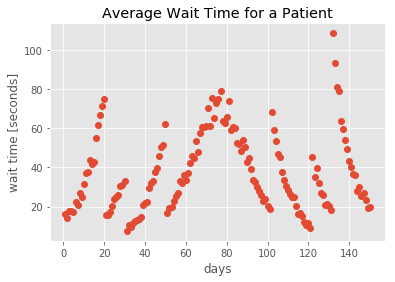

In [27]:
# create data of the simulation results 
Tx = np.linspace (1, 150, 150)
tx = avg_wait_time * 3600

# create graph representing the daily results
plt.plot (Tx, tx, 'o')
plt.title ("Average Wait Time for a Patient")
plt.xlabel ("days")
plt.ylabel ("wait time [seconds]")
plt.show ()

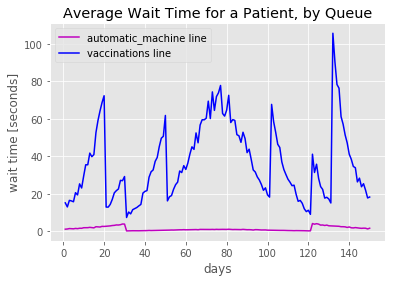

In [28]:
# create data of the simulation results 
Tx = np.linspace (1, 150, 150)
x1 = avg_wait_time_queue1 * 3600
x2 = avg_wait_time_queue2 * 3600

# create graph representing the daily results
plt.plot (Tx, x1, 'm', Tx, x2, 'b')
plt.title ("Average Wait Time for a Patient, by Queue")
plt.xlabel ("days")
plt.ylabel ("wait time [seconds]")
plt.legend (('automatic_machine line', 'vaccinations line'))
plt.show ()

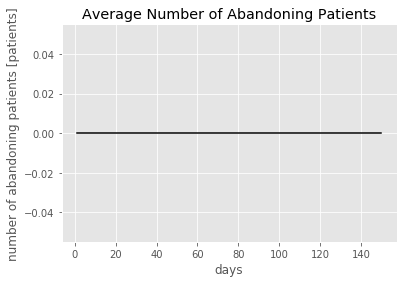

In [29]:
# create data of the simulation results 
Tx = np.linspace (1, 150, 150)
tx = avg_abandoning_patients

# create graph representing the daily results
plt.plot (Tx, tx, 'k')
plt.title ("Average Number of Abandoning Patients")
plt.xlabel ("days")
plt.ylabel ("number of abandoning patients [patients]")
plt.show ()

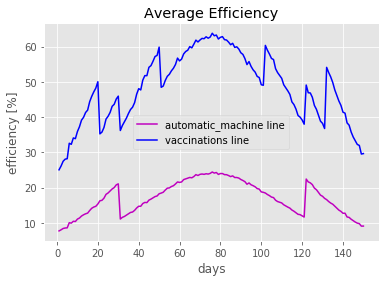

In [30]:
# create data of the simulation results 
Tx = np.linspace (1, 150, 150)
x1 = (avg_efficiency_machine) * 100
x2 = (avg_efficiency_medical_staff) * 100

# create graph representing the daily results
plt.plot (Tx, x1, 'm',Tx, x2, 'b')
plt.title ("Average Efficiency")
plt.xlabel ("days")
plt.ylabel ("efficiency [%]")
plt.legend (('automatic_machine line', 'vaccinations line'))
plt.show ()

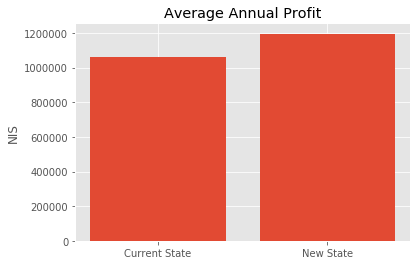

In [31]:
# create data of the profit results 
D = {u'Current State': A_profit, u'New State': alternative_A_profit}

# create graph representing the profit results in both states
dictionary = plt.figure()
plt.title ("Average Annual Profit")
plt.bar (range(len(D)), D.values (), align= 'center')
plt.xticks (range(len(D)), D.keys ())
plt.ylabel ("NIS")
plt.show ()

# Step 3.3: Two-Way Speculation Test for Profit Expectation

## H0: μ2 - μ1 = 0
## H1: μ2 - μ1 ≠ 0

In [32]:
miu2 = alternative_A_profit
miu1 = A_profit

Difference_Profit = alternative_sum_profit - sum_profit
std = np.std (Difference_Profit)
t = stats.t.ppf (1 - alpha/2, N - 1)
h0 = (t * std)/math.sqrt(N)
d = np.mean (Difference_Profit)

print ("Confidence interval for the profit's difference (between new and current state):", [d - h0, d + h0])

if d - h0 > 0 and d + h0 > 0:
    print ("The alternative profit expectation:", miu2, "NIS, is higher than the current profit expectation:", miu1, "NIS")
    print ("in confidence level of", (1 - alpha) * 100, "%")

else:
    print ("The alternative profit expectation:", miu2, "NIS, is not higher than the current profit expectation:", miu1, "NIS")
    print ("in confidence level of", (1 - alpha) * 100, "%")

Confidence interval for the profit's difference (between new and current state): [131843.18589004944, 137235.45785241848]
The alternative profit expectation: 1195897.36924 NIS, is higher than the current profit expectation: 1061358.04736 NIS
in confidence level of 95.0 %
